# 0.0 Tabel of Contents

[Fillout NA](#1.5-Fillout-NA) <br>
[Numerical Attibutes](#1.7.1-Numerical-Attributes)

# 0. IMPORTS

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import inflection
import math
import datetime as datetime

from IPython.display import Image
from scipy import stats

# o comando mágico abaixo é para o kernel XPython mostrar os gráficos na célula
%matplotlib inline

## 0.1. Helper Functions

## 0.2. Loading data

In [2]:
df_sales_raw = pd.read_csv( 'data/train.csv', low_memory = False)
df_store_raw = pd.read_csv( 'data/store.csv', low_memory = False)

# merge
df_raw = pd.merge(df_sales_raw,df_store_raw, how='left', on = 'Store' )

# 1.0. DESCRICAO DOS DADOS

In [3]:
# é interessante copiar o df no início de cada seção para evitar que, caso seja alterado o conteúdo do df, não seja necessário rodar todo o código novamente
df1 = df_raw.copy()

## 1.1. Rename Columns

In [4]:
cols_old = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo','StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
            'CompetitionDistance', 'CompetitionOpenSinceMonth','CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek','Promo2SinceYear', 'PromoInterval']

snakecase = lambda x: inflection.underscore(x)
cols_new = list(map(snakecase,cols_old))
df1.columns = cols_new

## 1.2 Data Dimensions

In [5]:
# imprimir o número de linhas e colunas usando 2 maneiras de interpolar strings
print(f'Number of Rows: {df1.shape[0]}')
print('Number of Columns: {}'.format(df1.shape[1]))

Number of Rows: 1017209
Number of Columns: 18


## 1.3 Data Types

In [6]:
# inicialmente, o date é object
# deve-se alterar o tipo do date
df1['date'] = pd.to_datetime(df1['date'])

df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
dtype: object

## 1.4 Check NA

In [7]:
df1.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

## 1.5 Fillout NA

Existem 3 métodos principais: <br>
    - Removo todas as linhas com NA: método possui a imensa desvantagem de perder muita informação <br>
    - Uso algum algoritmo para preencher os dados NA, como média, mediana ou algum ML para estimar os valores <br>
    - Entender a razão pela qual é NA; sempre devo começar por este método, pois eventualmente o NA era esperado
    

In [8]:
#competition_distance: distance in meters to the nearest competitor store

# o código abaixo revela que existem 3 lojas (622, 291 e 879) que possuem esta coluna em branco
stores = df1[df1["competition_distance"].isna()]["store"].value_counts()
display(stores)
print("\n")

# o código abaixo revela que existem as mesmas quantidades de linhas que trazem os dados destas stores em relação
# à quantidade de linhas com o valor da distância do competidor mais próximo igual a NA
# com isso conclui-se que todas as linhas dessas 3 stores estão, de fato, com o valor NA para competition_distance
for store in stores.index:
    print(df1[df1["store"] == store].shape[0])
print("\n")  
    
# portanto, é razoável assumir que este valor NA para a competition distance significa que não há loja competidora próxima
# será então substituída por um vlaor muito maior que a distância máxima
# antes, precisamos saber o a distância máxima presente no dataset
print((df1["competition_distance"].max()))
print("\n") 

# sabendo que a distância máximo é 75860, podemos substituir por 200.000, por exemplo
df1["competition_distance"] = df1["competition_distance"].fillna(200000)

# finalmente, checando se atribuiu corretamente
print("Após a modificação, agora há " + str(df1["competition_distance"].isna().sum()) + " valor faltante")

622    942
291    942
879    758
Name: store, dtype: int64



942
942
758


75860.0


Após a modificação, agora há 0 valor faltante


In [9]:
#competition_open_since_month:  gives the approximate year and month of the time the nearest competitor was opened

# para a primeira interação do CRISP, para aquelas lojas que eu não tenho a informação sobre quando a loja competidora abriu,
# vou simplesmente alocar o mesmo mês da linha de venda. Mesmo não sendo lógico, se for preciso na segunda interação do método CRISP
# poderei alterar esta atribuição.
# um motivo para essa suposição é que o mês e ano que uma loja competidora abriu pode significar um evento no comportamento de vendas
# tal evento pode ser detectado lá no feature selection
# logo, se o mês e ano da loja competidora "acompanham" o mês e ano da data da venda, não haverá nenhuma consequência nas vendas para as linhas que
# inicialmente estavam NA


x = lambda x: x["date"].month if math.isnan(x["competition_open_since_month"]) else x["competition_open_since_month"]
df1["competition_open_since_month"] = df1.apply(x, axis=1)

# o mesmo raciocínio para o "competition_open_since_month" vale para o "competition_open_since_year", promo2_since_week e promo2_since_year
#competition_open_since_year
x = lambda x: x["date"].year if math.isnan(x["competition_open_since_year"]) else x["competition_open_since_year"]
df1["competition_open_since_year"] = df1.apply(x, axis=1)

#promo2_since_week
x = lambda x: x["date"].week if math.isnan(x["promo2_since_week"]) else x["promo2_since_week"]
df1["promo2_since_week"] = df1.apply(x, axis=1)

#promo2_since_year
x = lambda x: x["date"].year if math.isnan(x["promo2_since_year"]) else x["promo2_since_year"]
df1["promo2_since_year"] = df1.apply(x, axis=1)


In [10]:
#promo_interval: describes the consecutive intervals Promo2 is started, naming the months the promotion is started anew. 
#E.g. "Feb,May,Aug,Nov" means each round starts in February, May, August, November of any given year for that store

# para a primeira rodada do CRISP, será atribuído o valor 0 (zero) para os dados faltantes da coluna "promo_interval"
df1["promo_interval"].fillna(0, inplace = True)

# a seguir, será verificado se o mês da data da linha é mês de início de rodada da promo2 e atribuído à nova coluna "is_promo:
# 0 (quando não é mês de de início) ou 1 (quando é mês de início)
month_map = {1: "Jan", 2: "Feb", 3: "Mar", 4: "Apr", 5: "May", 6: "Jun", 7: "Jul", 8: "Aug",9: "Sept", 10: "Oct", 11: "Nov",12: "Dec"}
df1["month_map"] = df1["date"].dt.month.map(month_map)

# escrevi 2 maneiras de executar a função que popula a nova coluna "is_promo"
# a primeira demora +10 min e por isso foi inteiramente comentada:

#def isPromo(df):
#    if df["promo_interval"] == 0:
#        df["is_promo"] = 0
#    else:
#        if df["month_map"] in df["promo_interval"].split(','):
#            df["is_promo"] = 1
#        else:
#            df["is_promo"] = 0
#    return df
            
# df1["is_promo"] = df1[["promo_interval","month_map"]].apply(isPromo, axis = 1)["is_promo"]
# Last executed at 2021-04-08 09:14:02 in 13m 57.15s


# a segunda demora menos de 15 segundos:
df1["is_promo"] = df1[["promo_interval","month_map"]].apply(lambda x: 0 if x["promo_interval"] == 0 else 1 if x["month_map"] in x["promo_interval"].split(',') else 0, axis = 1)
# Last executed at 2021-04-08 08:53:43 in 11.97s

In [11]:
# confirma que todos os dados faltantes foram tratados
df1.isna().sum()

store                           0
day_of_week                     0
date                            0
sales                           0
customers                       0
open                            0
promo                           0
state_holiday                   0
school_holiday                  0
store_type                      0
assortment                      0
competition_distance            0
competition_open_since_month    0
competition_open_since_year     0
promo2                          0
promo2_since_week               0
promo2_since_year               0
promo_interval                  0
month_map                       0
is_promo                        0
dtype: int64

## 1.6 Change Types


In [12]:
# as operações realizadas em 1.5 podem ter mudado os tipos das colunas.
# por isso é importante checar novamente
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
month_map                               object
is_promo                                 int64
dtype: object

In [13]:
# mudar o tipo das colunas que tem semana, mês e ano
df1["competition_open_since_month"] = df1["competition_open_since_month"].astype(int)
df1["competition_open_since_year"] = df1["competition_open_since_year"].astype(int)
df1["promo2_since_week"] = df1["promo2_since_week"].astype(int)
df1["promo2_since_year"] = df1["promo2_since_year"].astype(int)

# a princípio não há nenhum problema em deixar algumas colunas como int32 e outras como int64
# caso seja necessária a conversão: valor_64 = np.int64(valor32_a_ser_convertido)

## 1.7 Descriptive Statistical

A partir deste momento, passamos para a exploração dos dados da metodologia CRISP

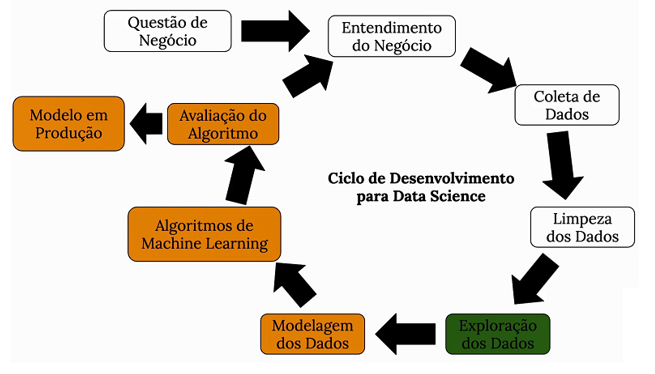

In [14]:
Image("img/crisp.png")

Métricas: <br>
* Tendência central: média, mediana
* Dispersão: variância, desvio padrão, amplitude

Embora a estatística descritiva seja compatível com dados numéricos e categóricos, a forma de construção é diferente. Portanto, preciso separar em dados numéricos e dados categóricos.

In [15]:
num_attributes = df1.select_dtypes(include=['int32', 'int64', 'float64'])
cat_attributes = df1.select_dtypes(exclude=['int32', 'int64', 'float64','datetime64[ns]'])

### 1.7.1 Numerical Attributes

In [16]:
# mean, median
ct1 = pd.DataFrame(num_attributes.apply(np.mean)).T
ct2 = pd.DataFrame(num_attributes.apply(np.median)).T

# std, min, max, range, skew, kurtosis
d1 = pd.DataFrame(num_attributes.apply(np.std)).T
d2 = pd.DataFrame(num_attributes.apply(np.min)).T
d3 = pd.DataFrame(num_attributes.apply(np.max)).T
d4 = pd.DataFrame(num_attributes.apply(lambda x: x.max() - x.min() )).T
d5 = pd.DataFrame(num_attributes.skew()).T
d6 = pd.DataFrame(num_attributes.kurtosis()).T

# concat
metrics = pd.concat([d2, d3, d4, ct1, ct2, d1, d5, d6]).T.reset_index()
metrics.columns = ['attributes', 'min','max','range','mean','median','std','skew','kurtosis']


<AxesSubplot:xlabel='sales', ylabel='Count'>

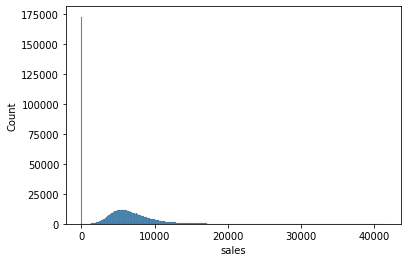

In [17]:
sns.histplot(df1["sales"])

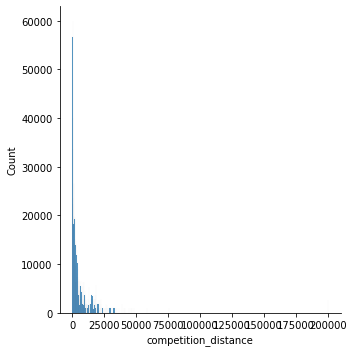

In [18]:
sns.displot(df1["competition_distance"])

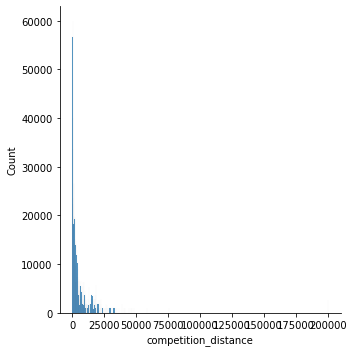

In [19]:
sns.displot(df1["competition_distance"])

### 1.7.2 Categorical Attributes

In [20]:
cat_attributes.apply(lambda x: x.unique().shape[0])

# outra maneira de obter o mesmo resultado
#cat_attributes.nunique()

state_holiday      4
store_type         4
assortment         3
promo_interval     4
month_map         12
dtype: int64

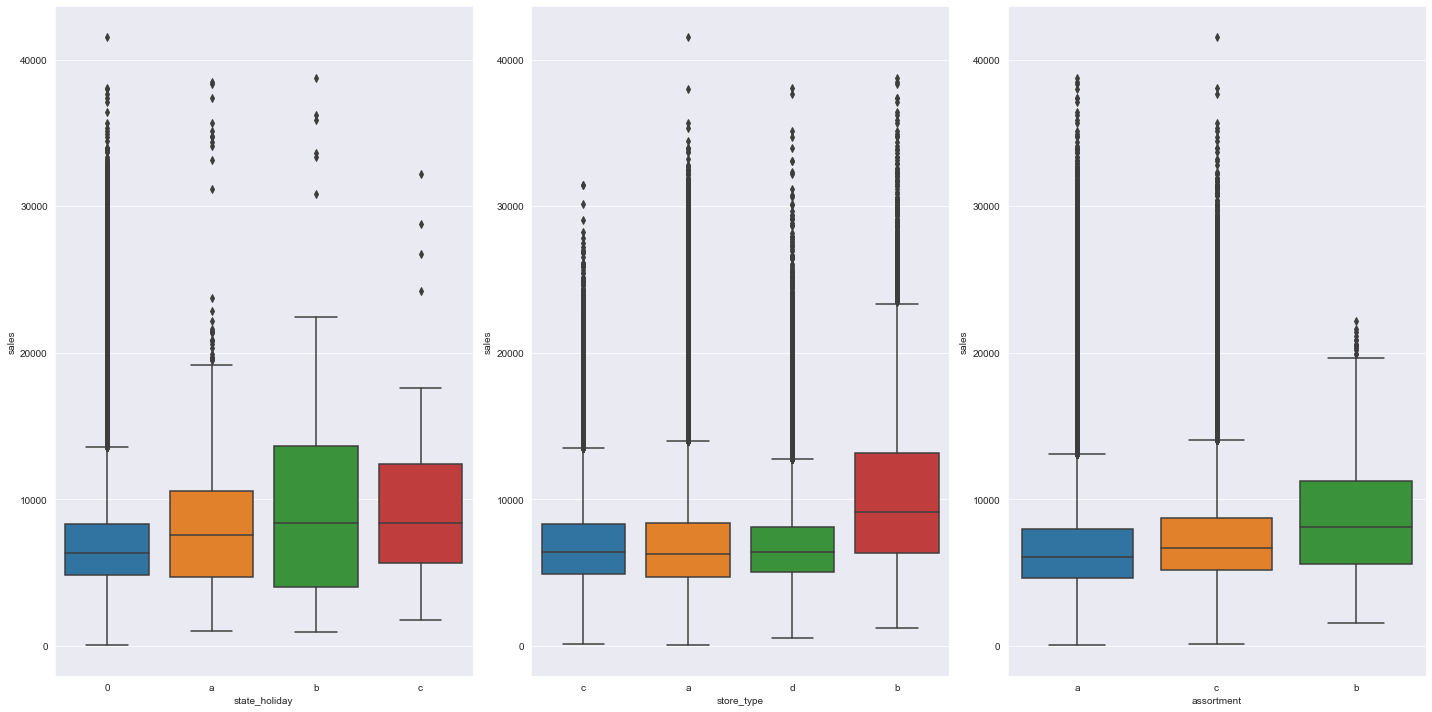

In [21]:
# desconsiderar quando as lojas estavam fechadas ou quando a venda foi nula
aux1 = df1[(df1["open"] == 1) & (df1["sales"] > 0)]
sns.set_style("darkgrid")
plt.figure(figsize=(20,10))

plt.subplot(1,3,1)
sns.boxplot(x="state_holiday", y="sales", data=aux1)

plt.subplot(1,3,2)
sns.boxplot(x="store_type", y="sales", data=aux1)

plt.subplot(1,3,3)
sns.boxplot(x="assortment", y="sales", data=aux1)

plt.tight_layout()

Nos gráficos de boxplot acima, os outliers são aqueles considerados acima de 1.5  do intervalor interquartil (IQR, em inglês)
A imagem abaixo ilustra isso

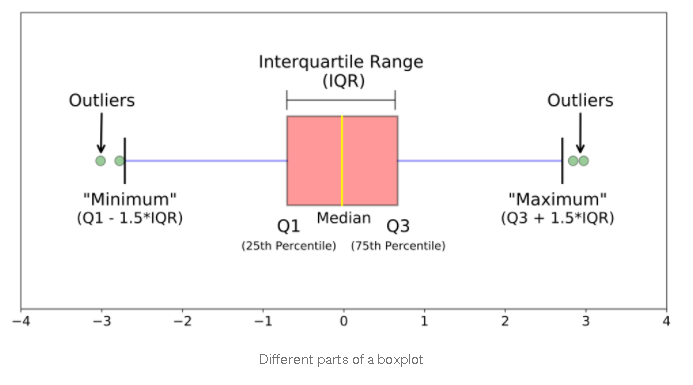

In [22]:
# fonte: https://towardsdatascience.com/understanding-boxplots-5e2df7bcbd51
Image("img/box_plot.png")

# 2.0 FEATURE ENGINEERING

In [23]:
df2 = df1.copy()

## 2.1 Mapa mental de hipóteses

Mapa mental de hipóteses:
* Fenômeno: O que estou modelando (Daily Store Sales)
* Agentes: Quais são os agentes que atuam sobre o fenômeno (cinco galhos principais)
* Atributos dos Agentes: Qual a descrição dos agentes (galhos em cada um dos agentes) <br>

O objetivo é derivar uma lista de hipóteses para podermos validá-las ou não com os dados.
Cada hipótese validada ou descartada é o insight.

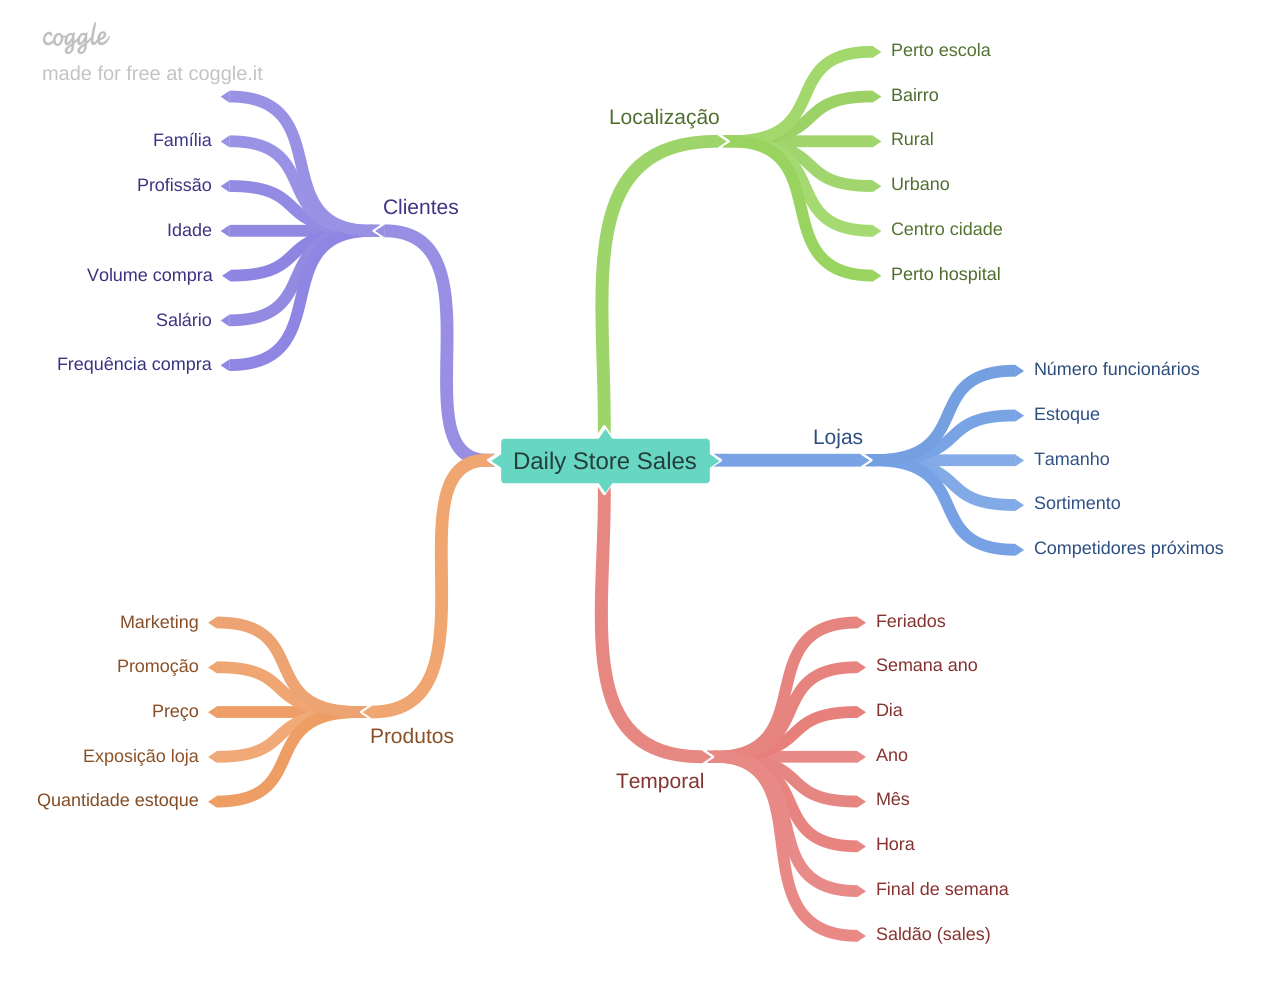

In [24]:
# gerado com ajuda de https://coggle.it/
Image("img/MindMapHypothesis.png")

O mapa mental de hipóteses acima será utilizado para extrair hipóteses para validá-las, mais a frente, durante a análise exploratória de dados.
Para escrever hipóteses, considerá-las como uma aposta, conforme os exemplos abaixo: <br>
"Lojas de MAIOR porte deveriam vender MAIS." (Repare que estou citando um atributo de um agente (Tamanho da loja) e apostando na correlação sobre a variável resposta (vendas). <br>
"Lojas de MAIOR sortimento deveriam vender MAIS." <br>
"Lojas com MAIS competidores por perto deveriam vender MENOS."


## 2.1 Criação das hipóteses

### 2.1.1. Hipóteses Loja

**1.** Lojas com maior quadro de funcionários deveriam vender mais <br>
**2.** Lojas com maior estoque deveriam vender mais <br>
**3.** Lojas com maior porte deveriam vender mais (ou Lojas com menor porte deveriam vender menos) <br>
**4.** Lojas com maior sortimento deveriam vender mais <br>
**5.** Lojas com competidores mais próximos deveriam vender menos <br>
**6.** Lojas com competidores à mais tempo deveriam vender mais

### 2.1.2. Hipóteses Produto

**1.** Lojas que investem mais em marketing deveriam vender mais <br>
**2.** Lojas que expõem mais nas vitrines da loja deveriam vender mais <br>
**3.** Lojas onde os produtos custam menos deveriam vender mais <br>
**4.** Lojas com promoções mais agressivas (descontos maiores) deveriam vender mais <br>
**5.** Lojas onde os produtos custam menos por mais tempo deveriam vender mais <br>
**6.** Lojas com mais dias de promoção deveriam vender mais <br>
**7.** Lojas com mais promoções consecutivas deveriam vender mais <br> 

### 2.1.3. Hipóteses Tempo

**1.** Lojas abertas durante o feriado de Natal deveriam vender mais <br>
**2.** Lojas deveriam vender mais ao longo dos anos <br>
**3.** Lojas deveriam vender mais no segundo semestre do ano <br>
**4.** Lojas deveriam vender mais depois do dia 10 de cada mês <br>
**5.** Lojas deveriam vender menos aos finais de semana <br>
**6.** Lojas deveriam vender menos durante os feriados escolares <br>
**7. (extra)** Lojas que abrem nos finais de semana deveriam vender mais <br>


## 2.2 Priorização de hipóteses

Como estamos trabalhando no método CRISP, vamos validar as hipoteses que já temos condições de verificá-las com o conjunto atual de dados obtidos. Se para a hipótese for necessário fazer mais um query no SQL, extrair, armazenar e tratar os dados, então é melhor fazer em um próximo ciclo do CRISP, caso necessário. <br>
As hipóteses abaixo foram extraídas das seções 2.1.1 a 2.1.3 pois, no dataset disponível, são as únicas que podem ser verificadas.

**1.** Lojas com maior sortimento deveriam vender mais <br>
**2.** Lojas com competidores mais próximos deveriam vender menos <br>
**3.** Lojas com competidores à mais tempo deveriam vender mais <br>

**4.** Lojas onde os produtos custam menos por mais tempo deveriam vender mais <br>
**5.** Lojas com mais dias de promoção deveriam vender mais <br>
**6.** Lojas com mais promoções consecutivas deveriam vender mais <br> 

**7** Lojas abertas durante o feriado de Natal deveriam vender mais <br>
**8.** Lojas deveriam vender mais ao longo dos anos <br>
**9.** Lojas deveriam vender mais no segundo semestre do ano <br>
**10.** Lojas deveriam vender mais depois do dia 10 de cada mês <br>
**11.** Lojas deveriam vender menos aos finais de semana <br>
**12.** Lojas deveriam vender menos durante os feriados escolares <br>
**13. (extra)** Lojas que abrem nos finais de semana deveriam vender mais <br>

## 2.3 Feature Engineering

In [25]:
# criação de novas colunas para utilizá-las na AED e validação/refutação das hipóteses selecionadas

# year
df2["year"] = df2["date"].dt.year
# month
df2["month"] = df2["date"].dt.month
# day
df2["day"] = df2["date"].dt.day
# week of year
df2["week_of_year"] = df2["date"].dt.isocalendar().week #capturar a semana do ano
# year week
df2["year_week"] = df2["date"].dt.strftime('%Y-%W')

# competition since (preciso juntar o ano e mês primeiro)
df2["competition_since"] = df2.apply(lambda x: datetime.datetime(year = x["competition_open_since_year"], month = x["competition_open_since_month"], day = 1), axis = 1)
df2["competition_time_month"] = ((df2["date"] - df2["competition_since"]) / 30).apply(lambda x: x.days).astype(int)


# promo since (queremos saber o tempo que a loja aderiu a promo2 )
# como a semana %W começa com 0, subtrai-se 7 dias
df2["promo_since"] = df2["promo2_since_year"].astype(str) +  '-' + df2["promo2_since_week"].astype(str)
df2["promo_since"] = df2["promo_since"].apply(lambda x: datetime.datetime.strptime(x + '-1', '%Y-%W-%w' ) - datetime.timedelta(days=7))

df2["promo_time_week"] = ((df2["date"] - df2["promo_since"])/7).apply(lambda x: x.days).astype(int)

# assortment
df2["assortment"] = df2["assortment"].map({'a': 'basic', 'b': 'extra', 'c': 'extended'})
# state holiday
df2["state_holiday"] = df2["state_holiday"].map({'a':'public_holiday', 'b':'easter_holiday', 'c':'christmas', '0': 'regular_day'})


In [26]:
df2.head().T

,0,1,2,3,4
store,1,2,3,4,5
day_of_week,5,5,5,5,5
date,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00
sales,5263,6064,8314,13995,4822
customers,555,625,821,1498,559
open,1,1,1,1,1
promo,1,1,1,1,1
state_holiday,regular_day,regular_day,regular_day,regular_day,regular_day
school_holiday,1,1,1,1,1
store_type,c,a,a,c,a


In [27]:
df2.state_holiday.value_counts()

regular_day       986159
public_holiday     20260
easter_holiday      6690
christmas           4100
Name: state_holiday, dtype: int64

# 3.0 FILTRAGEM DE VARIÁVEIS

A motivação para a filtragem de negócios são as restrições de negócio. É possível que, lá na frente, o CD se depara com a impossibilidade de colocar o modelo em produção. Isso ocorre, principalmente, devido à falta de consideração das restrições de negócio. Por isso ela é importante estar dentro do início do ciclo do CRISP. <br>
Um exemplo de restrição de negócios que foi mencionado na aula: no desenvolvimento de um projeto para previsão de vendas de um produto, verificou-se que a variável "desconto aplicado" tinha forte correlação com o volume de vendas. O modelo então foi treinado usando-se essa variável. Mas o time de negócios falou que era impossível saber o desconto antes do produto ser lançado. Logo, no momento da predição, na produção, não é possível usá-la. Por isso é importante filtrar as variáveis antes de começar o projeto em si.

In [28]:
df3 = df2.copy()

## 3.1 Filtragem das linhas

In [29]:
# a coluna "open" indica se a loja está aberta (1) ou fechada (0); porém quando ela está fechada, as vendas são 0; logo não tenho nenhum aprendizado extraído das linhas onde "open" é igual a 0
# a coluna "sales" quando indica o valor 0, semelhantemente em relação à coluna "open", não há aprendizado a ser extraído, logo não usarei as linhas onde isso ocorre

df3 = df3[(df3['open'] != 0) & (df3['sales'] > 0)]

## 3.2 Seleção das colunas

In [30]:
# a coluna "customers" não temos no momento da predição; não sabemos quantos customers terão daqui 6 semanas (para isso seria necessário um outro projeto)
# também serão excluídas as colunas 'open' (que após 3.1 só apresenta o valor '1') e as colunas 'promo_interval' e 'month_map' que foram utilizadas para derivar a coluna 'is_promo'
cols_drop = ['customers', 'open', 'promo_interval', 'month_map']
df3 = df3.drop(cols_drop, axis=1)

In [31]:
# para o pandas mostrar o dataframe completo, sem restrição no número de colunas a ser exibido, posso alterar a seguitne opção:
pd.set_option('max_columns', None)
df3.head()

,store,day_of_week,date,sales,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week
0,1,5,2015-07-31,5263,1,regular_day,1,c,basic,1270.0,9,2008,0,31,2015,0,2015,7,31,31,2015-30,2008-09-01,84,2015-07-27,0
1,2,5,2015-07-31,6064,1,regular_day,1,a,basic,570.0,11,2007,1,13,2010,1,2015,7,31,31,2015-30,2007-11-01,94,2010-03-22,279
2,3,5,2015-07-31,8314,1,regular_day,1,a,basic,14130.0,12,2006,1,14,2011,1,2015,7,31,31,2015-30,2006-12-01,105,2011-03-28,226
3,4,5,2015-07-31,13995,1,regular_day,1,c,extended,620.0,9,2009,0,31,2015,0,2015,7,31,31,2015-30,2009-09-01,71,2015-07-27,0
4,5,5,2015-07-31,4822,1,regular_day,1,a,basic,29910.0,4,2015,0,31,2015,0,2015,7,31,31,2015-30,2015-04-01,4,2015-07-27,0


# 4.0 ANÁLISE EXPLORATÓRIA DOS DADOS

Como as variáveis impactam o fenômeno & qual é a força desse impacto?

Os 3 objetivos da EDA:
- Ganhar experiência de negócio
- Validar hipóteses de negócio (insights)
    - Gerar surpresa e contrapor crenças cristalizadas empiricamente pelo time de negócios
- Perceber variáveis que são importantes para o modelo

As seguintes análises serão efetuadas na EDA:
- Análise univariada
    - Como é essa variável (min, max, range, distribuição) ?
- Análise bivariada
    - Como a variável impacta no atributo alvo (carrelação, validação das hipóteses) ?
- Análise multivariada
    - Como as variáveis se relacionam (correlação entre elas) ?

In [32]:
df4 = df3.copy()

## 4.1 Análise univariada

### 4.1.1 Target variable

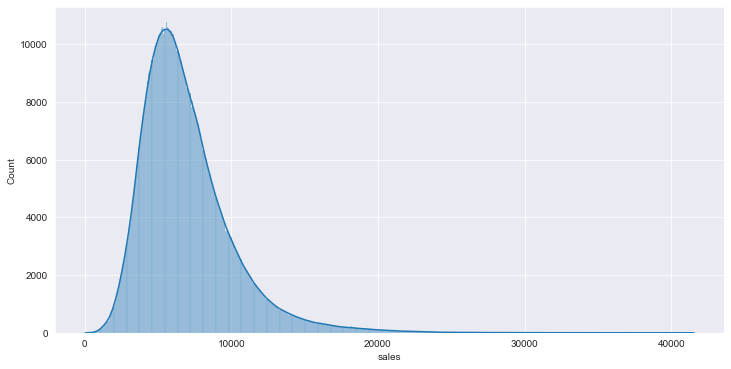

In [33]:
fig, ax = plt.subplots(figsize=(12,6))
sns.histplot(df4['sales'], kde = True, ax = ax)
plt.show()

Uma curiosidade: foi mencionado que ao aplicar o log1p na distribuição (que não é normal) deixaria a distribuição "mais normal"; entretanto, usando o normal test do scipy não notamos diferença. Este tópico certamente será muito discutido ao longo dos meus estudos e deixo registrado aqui esta observação.
Outro método que foi mencionada para transformar a distribuição em normal é a boxcox, que também não alterou o valor do p no normaltest

In [34]:
a = (df4['sales']) 
b = np.log1p(df4['sales'])  #transf. log1p
c, _ = stats.boxcox(df4['sales']) #trans. boxcox
testes = ['a', 'b', 'c']

for teste in testes:
    k2, p = stats.normaltest(eval(teste))
    print(f'O p valor de {teste} é {p}')

O p valor de a é 0.0
O p valor de b é 0.0
O p valor de c é 0.0


### 4.1.2 Numerical variable

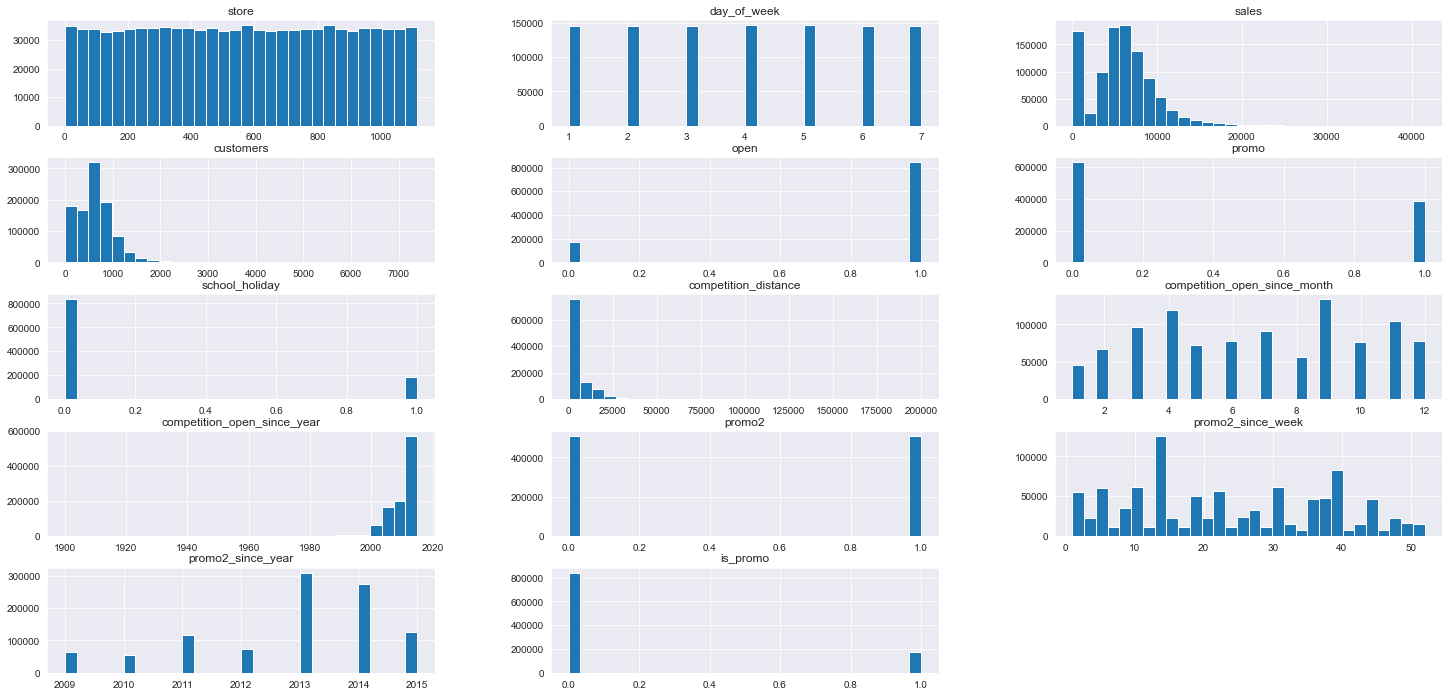

In [49]:
ax = num_attributes.hist(bins=30, figsize = (25,12), layout=(5,3));
plt.show()

Algumas análises preliminares:
- o número de dados de cada loja é aproximadamente igual
- a disponibilização de dadoos de venda em cada um dos 7 dias da semana também é uniforme
- a distribuição do valor das vendas obtidos pelas diferentes lojas não segue uma distribuição normal
- a mesma distribuição das vendas parece ocorrer para o número de clientes
- a maior parte dos competidores parece que abriram em setembro, seguido por abril
- a promo2 está presente em metade dos dados disponíveis
- o ano onde mais ocorreu início da promo2 foi 2013
- a promo2 parece que tende a iniciar mais no primeiro semestre do ano (26 primeiras semanas)

### 4.1.3 Categorical variable

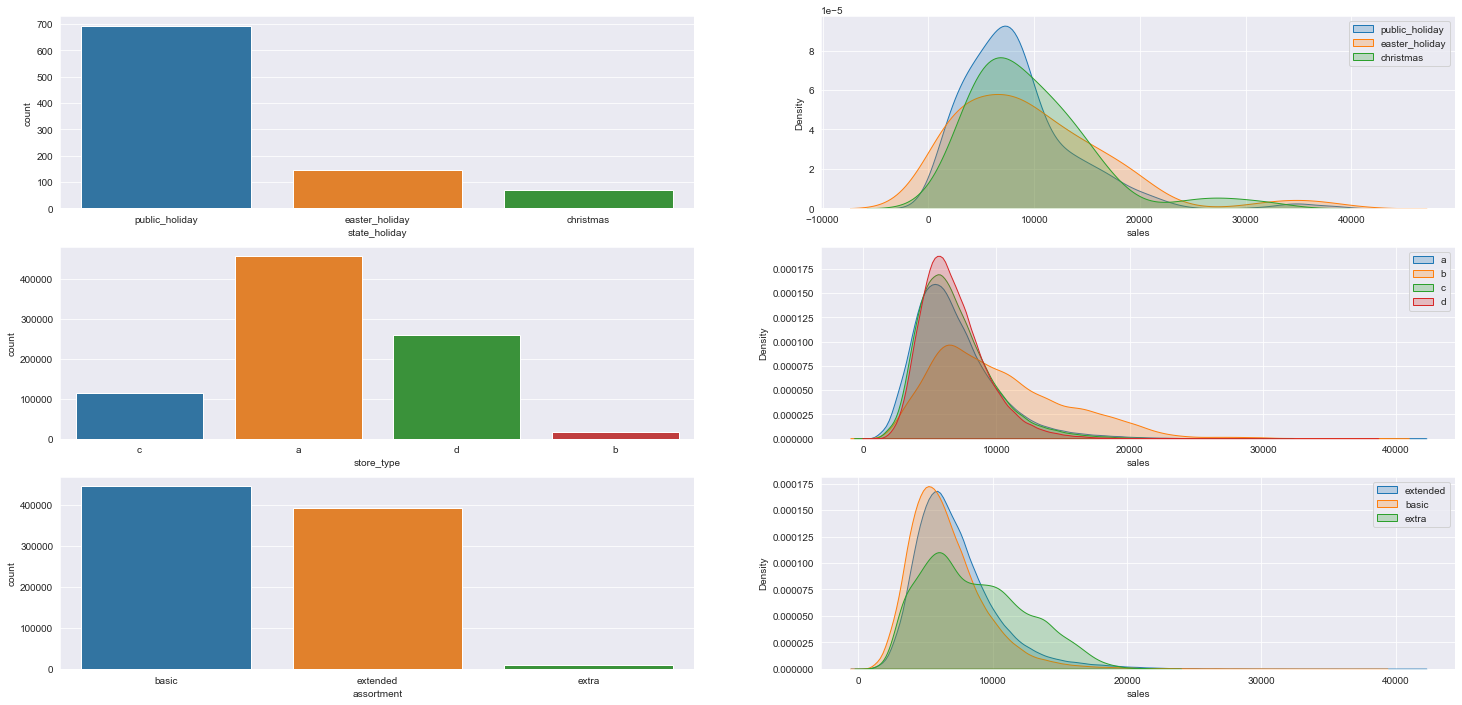

In [36]:
plt.figure(figsize=(25,12))

# state_holiday
plt.subplot(3,2,1)
sns.countplot(data = df4[df4['state_holiday'] != 'regular_day'],x = 'state_holiday')

plt.subplot(3,2,2)
sns.kdeplot(df4[df4['state_holiday'] == 'public_holiday']['sales'], label = 'public_holiday', shade=True)
sns.kdeplot(df4[df4['state_holiday'] == 'easter_holiday']['sales'], label = 'easter_holiday', shade=True)
sns.kdeplot(df4[df4['state_holiday'] == 'christmas']['sales'], label = 'christmas', shade=True)
plt.legend()

# store_type
plt.subplot(3,2,3)
sns.countplot(data = df4, x = 'store_type')

plt.subplot(3,2,4)
sns.kdeplot(df4[df4['store_type'] == 'a']['sales'], label = 'a', shade=True)
sns.kdeplot(df4[df4['store_type'] == 'b']['sales'], label = 'b', shade=True)
sns.kdeplot(df4[df4['store_type'] == 'c']['sales'], label = 'c', shade=True)
sns.kdeplot(df4[df4['store_type'] == 'd']['sales'], label = 'd', shade=True)
plt.legend()

# assortment
plt.subplot(3,2,5)
sns.countplot(data = df4, x = 'assortment')

plt.subplot(3,2,6)
sns.kdeplot(df4[df4['assortment'] == 'extended']['sales'], label = 'extended', shade=True)
sns.kdeplot(df4[df4['assortment'] == 'basic']['sales'], label = 'basic', shade=True)
sns.kdeplot(df4[df4['assortment'] == 'extra']['sales'], label = 'extra', shade=True)

plt.legend()

plt.show()

## 4.2 Análise bivariada

### H1. Lojas com maior sortimento deveriam vender mais

**verdadeira:** lojas com maior sortimento tendem a vender mais

Primeiramente, observa-se a quantidade de cada loja representante de cada sortimento.

In [37]:
df4[['store','assortment']].drop_duplicates().groupby('assortment').count()

,store
assortment,
basic,593
extended,513
extra,9


Como há considerável variação, principalmente em relação aos tipos "extra", vamos efetuar uma análise do desempenho médio por cada um desses tipos de sortimento presentes nas lojas.

In [38]:
df4[['assortment', 'sales']].groupby('assortment').describe()

sales                                                    \
               count         mean          std     min     25%     50%   
assortment                                                               
basic       444875.0  6621.523057  2972.050174    46.0  4611.0  6082.0   
extended    391254.0  7300.843547  3183.849717   133.0  5156.0  6675.0   
extra         8209.0  8642.503594  3803.116031  1580.0  5606.0  8088.0   

                              
                75%      max  
assortment                    
basic        8000.0  38722.0  
extended     8703.0  41551.0  
extra       11271.0  22137.0

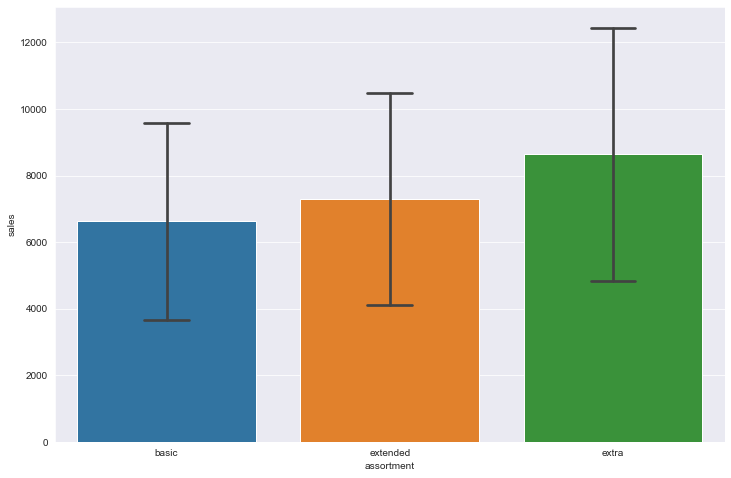

In [39]:
plt.figure(figsize=(12,8))
sns.barplot(x = 'assortment', y='sales', data = df4, estimator = np.mean, ci = 'sd',capsize=.2);

Para investigar o efeito sazonal de tais vendas em relação aos diferentes tipos de sortimento podemos criar uma série temporal

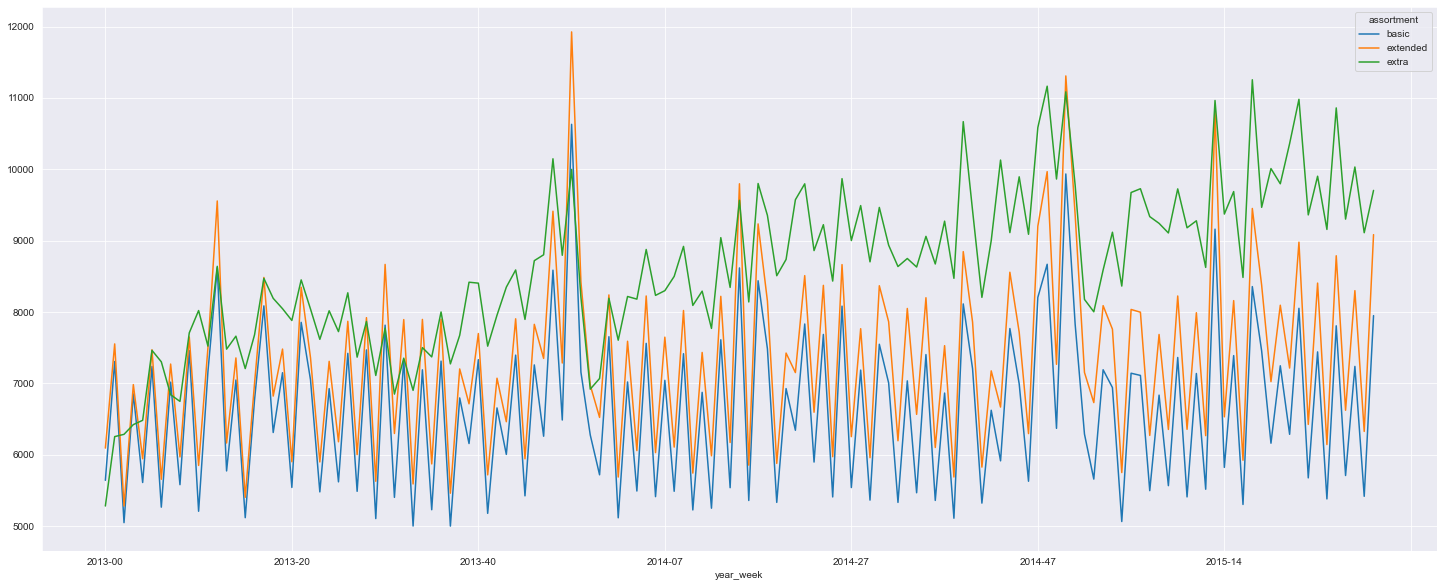

In [40]:
aux1 = df4[['year_week', 'assortment', 'sales']].groupby(['year_week','assortment']).mean().reset_index()
aux1.pivot(index='year_week', columns = 'assortment', values='sales').plot(figsize=(25,10));

Aparentemente há um descolamento do resultado de vendas obtido conforme o tempo passa para as lojas com sortimento "extra", em relação àquelas com sortimento "basic" e "extended".
Ao observar a média móvel mensal (4 semanas) fica mais nítido tal efeito.

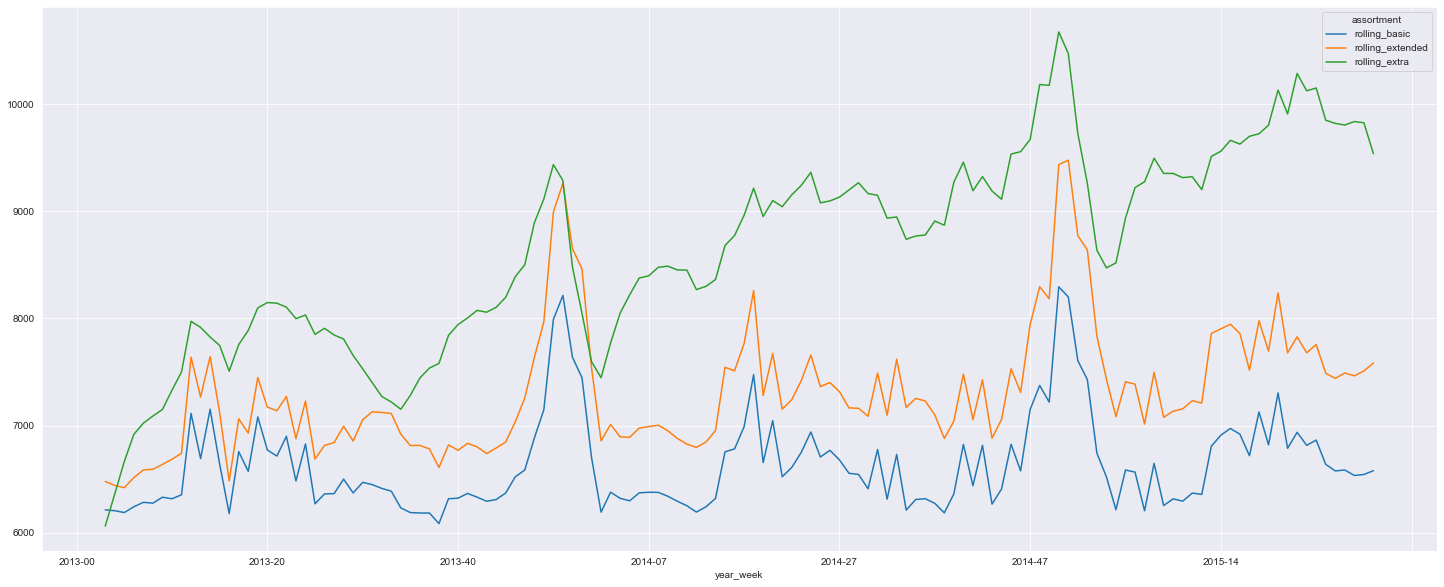

In [41]:
aux1 = df4[['year_week', 'assortment', 'sales']].groupby(['year_week','assortment']).mean().reset_index()
aux2 = aux1.pivot(index='year_week', columns = 'assortment', values='sales').reset_index()

aux2['rolling_basic'] = aux2['basic'].rolling(4).mean()
aux2['rolling_extended'] = aux2['extended'].rolling(4).mean()
aux2['rolling_extra'] = aux2['extra'].rolling(4).mean()
aux2 = aux2.set_index('year_week')[['rolling_basic','rolling_extended','rolling_extra' ]]
aux2.plot(figsize=(25,10));


O veredito da hipótese H1 é que **"sim, lojas com maior sortimento tendem a vender mais"**

Chamo a atenção para o cuidado ao escolher a função estatística por trás de cada um desses gráficos. Na aula foi invocada a função "sum" ao invés de "mean" o que inverteu completamenet as análises:
- as vendas de lojas com sortimento "basic" pareceram maiores em relação ao sortimento "extended";
- as vendas de lojas com sortimento "extra" apareceram como sendo ínfimas

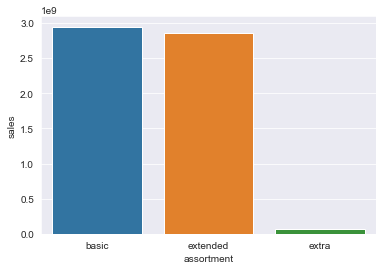

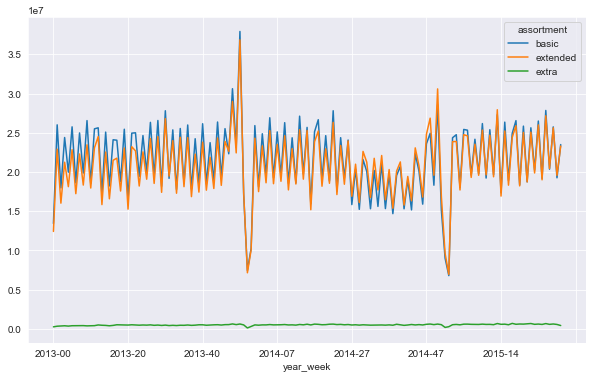

In [42]:
sns.barplot(x = 'assortment', y='sales', data=df4[['assortment', 'sales']].groupby('assortment').sum().reset_index());

aux1 = df4[['year_week', 'assortment', 'sales']].groupby(['year_week','assortment']).sum().reset_index()
aux1.pivot(index='year_week', columns = 'assortment', values='sales').plot(figsize=(10,6));

### H2. Lojas com competidores mais próximos deveriam vender menos
**falsa**: não, lojas com competidores mais próximos não vendem menos (ou mais) do que as lojas com competidores mais distantes


Ao plotar o valor médio de vendas em diferentes pequenos agrupamentos de intervalo de distância tem-se a distribuição a seguir:

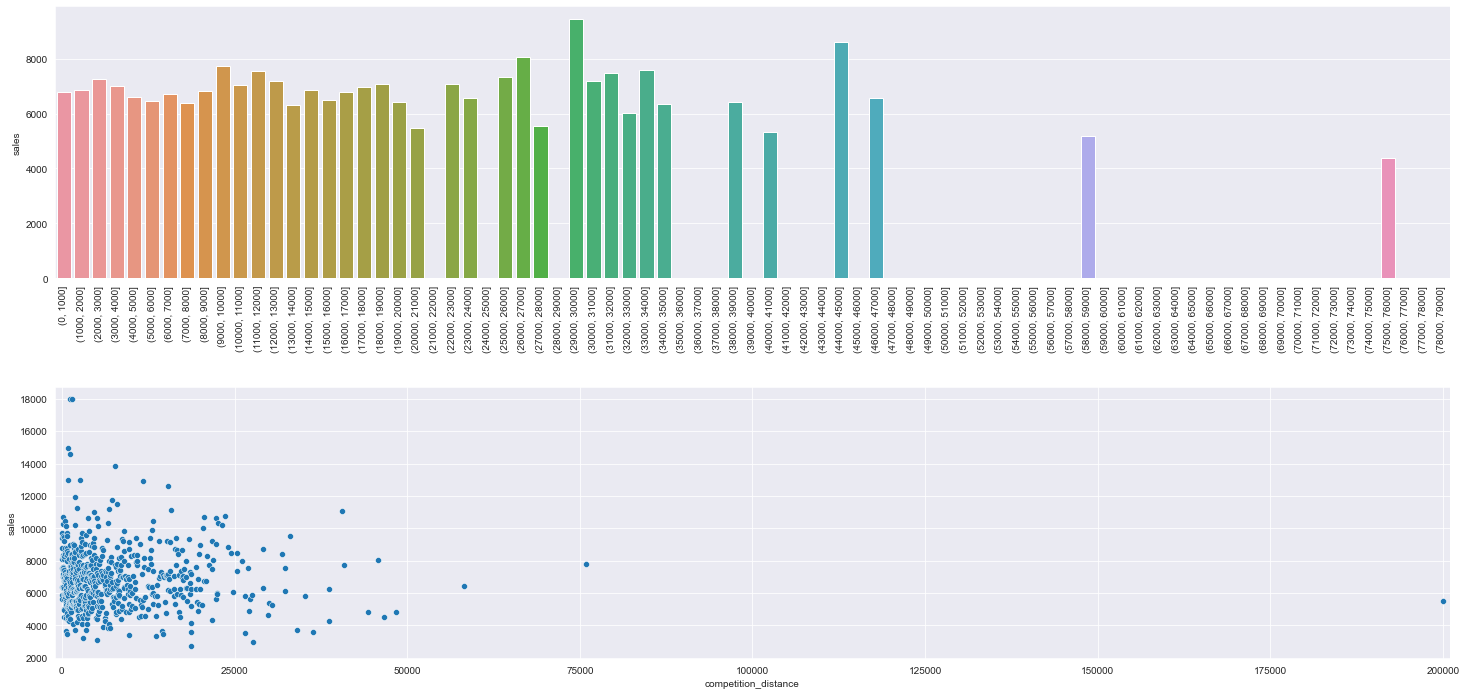

In [43]:
aux1 = df4[['competition_distance','sales']].groupby('competition_distance').mean().reset_index()
bins = list(np.arange(0,80000, 1000))
aux1['competition_distance_binned'] = pd.cut(df4['competition_distance'], bins = bins)
aux2 = aux1[['competition_distance_binned','sales']].groupby('competition_distance_binned').mean().reset_index()
plt.figure(figsize=(25,12))
plt.subplot(2,1,1)
plt.subplots_adjust(hspace=.4)
sns.barplot(data=aux2, x='competition_distance_binned', y='sales')
plt.xlabel("")
plt.xticks(rotation=90)

plt.subplot(2,1,2)
aux1 = df4[['competition_distance','sales']].groupby('competition_distance').mean().reset_index()
sns.scatterplot(x = 'competition_distance', y='sales', data=aux1)
plt.xlim(-1000,201000);


Pelos gráficos acima, não há nenhuma correlação aparente entre o valor médio de vendas e a distância do competidor mais próximo. Tal observação é confirmada ao plotar o gráfico de correlação de Pearson a seguir:

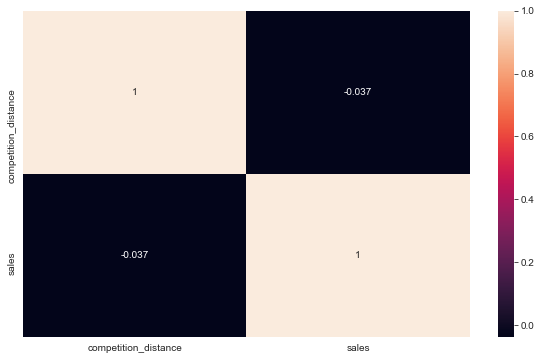

In [44]:
plt.figure(figsize=(10,6))
sns.heatmap(aux1.corr(method='pearson'),annot=True);

O veredito da hipótese H2 é que **"não, lojas com competidores mais próximos não vendem menos (ou mais) do que as lojas com competidores mais distantes "**

O mesmo comentário da H1 é feito aqui: se ao invés de considerar a média for considerada a soma das vendas, as análises serão completamente diferentes

<AxesSubplot:>

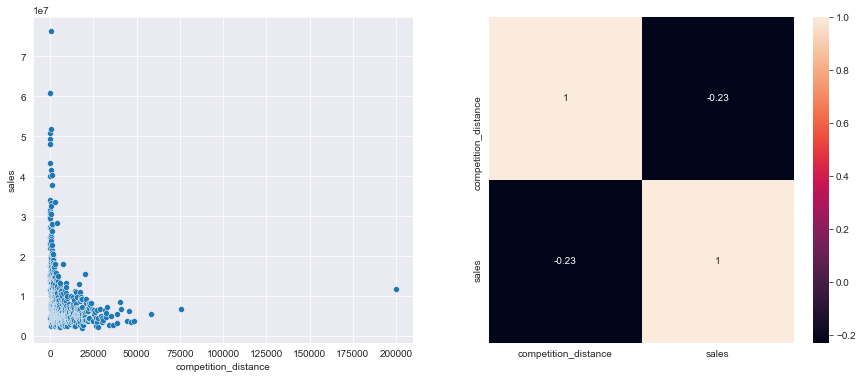

In [45]:
aux1 = df4[['competition_distance','sales']].groupby('competition_distance').sum().reset_index()
plt.figure(figsize=(15,6))
plt.subplot(1,2,1)
sns.scatterplot(x = 'competition_distance', y='sales', data=aux1)

plt.subplot(1,2,2);
sns.heatmap(aux1.corr(),annot=True)
                

### H3. Lojas com competidores à mais tempo deveriam vender mais
falsa: **não, lojas com competidores à mais tempo não vendem mais do que as lojas com competidores abertos mais recentemente**

Ao plotar o tempo que o competidor mais próximo está aberto tem-se a distribuição a seguir:

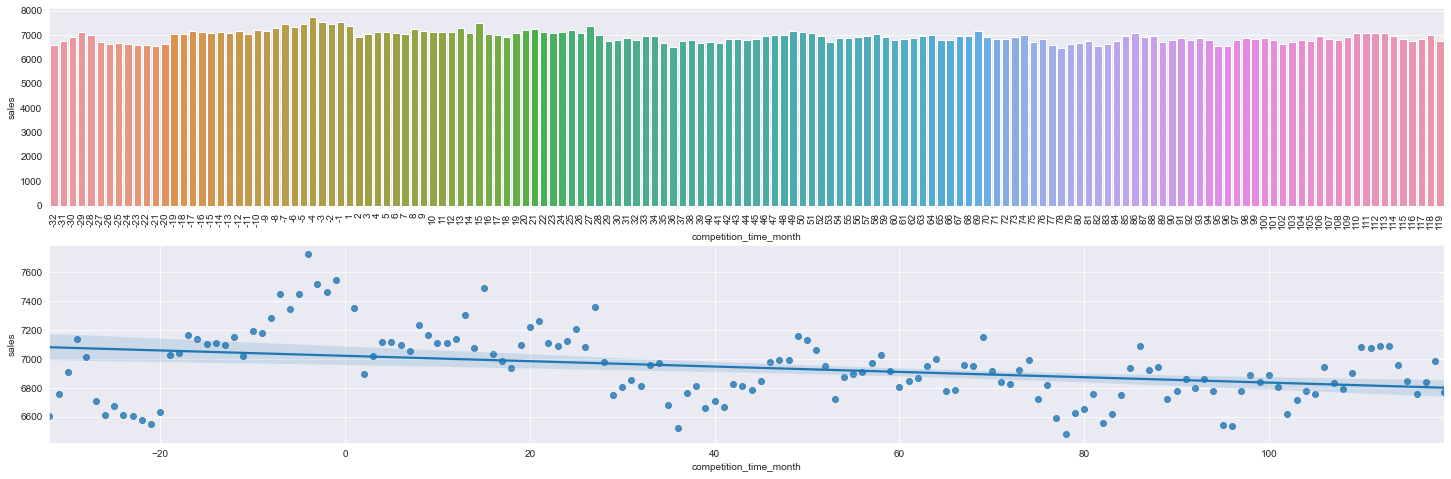

In [46]:
aux1 = df4[['competition_time_month', 'sales']].groupby('competition_time_month').mean().reset_index()
aux2 = aux1[(aux1['competition_time_month'] < 120) & (aux1['competition_time_month'] != 0)]

plt.figure(figsize=(25,8))
plt.subplot(2,1,1)
sns.barplot(x='competition_time_month', y='sales', data=aux2);
plt.xticks(rotation=90);

plt.subplot(2,1,2)
sns.regplot(x='competition_time_month', y='sales', data=aux2);

Os valores negativos devem-se aos registros de vendas antes do atual competidor mais próximo abrir.
Percebemos que há registros de tendência de maiores vendas meses antes (-12 a -1) dos competidores abrirem.
Ainda, uma vez que o competidor abre, as vendas iniciam uma tendência de queda, não sendo observado nenhuma recuperação significativa até pelo menos os 120 primeiros meses (10 anos) do competidor aberto.
Tal tendência também é sugerida na correlação de Pearson a seguir:

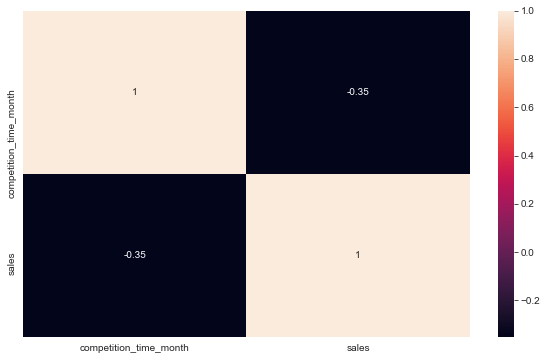

In [47]:
plt.figure(figsize=(10,6))
sns.heatmap(aux2.corr(method='pearson'),annot=True);

O veredito da hipótese H2 é que **"não, lojas com competidores à mais tempo não vendem mais do que as lojas com competidores abertos mais recentemente"**

## 4.3 Análise multivariada